# Сборный проект-4

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [1]:
import time
import pickle
import re
from collections import Counter
from os.path import exists, isfile, join
from pathlib import Path
import keras_nlp
from tensorflow import keras
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import LinearSVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange #загружаем библиотеки

Using TensorFlow backend


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
DATA_PATH = r'C:\Users\yana\Desktop\dsplus_integrated_project_4\to_upload'
SEED = 54321
BLOCK = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid', 'kids', 'newborn']

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def read_df(path=DATA_PATH) -> pd.DataFrame:

    # функция для открытия и прочтения файлов
    
    df_train = pd.read_csv(join(DATA_PATH, 'train_dataset.csv'))
    df_crowd = pd.read_csv(join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(join(DATA_PATH, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(join(DATA_PATH, 'test_images.csv'), sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

In [4]:
display(df_train.head(), df_crowd.head(), df_expert.head(), df_queries.head(), df_images.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

Узнаем количество уникальных фото в датасетах:

In [5]:
print('Количество уникальных фото на трейне:', len(df_train['image'].unique()))
print('Количество уникальных фото на тесте:', len(df_queries['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


При это количесвто уникальных запросов:

In [6]:
print('Количество уникальных запросов в тесте:', df_queries.drop_duplicates().shape[0])

Количество уникальных запросов в тесте: 500


Узнаем количество оценок в экспертном и краудсорсинговом датасетах:

In [7]:
print('Количество уникальных сочетаний фото-текст экспертные:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний фото-текст обычные:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст экспертные: 5822
Количество уникальных сочетаний фото-текст обычные: 47830


Проверим на соответствие текстовые сообщения и сами картинки:

In [8]:
df_queries[df_queries['query_id'].str[:-2] != df_queries['image']].shape[0]

0

Проверим соответствие тестовой и обучающей выборок:

In [9]:
print('Уникальные картинки в обучающем датасете:', len(set(df_train['image'])))
print('Уникальные картинки в тестовой выборке:', len(set(df_queries['image'])))
print('Уникальные картинки, которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальные картинки в обучающем датасете: 1000
Уникальные картинки в тестовой выборке: 100
Уникальные картинки, которые есть в обоих наборах: 0


Сэмпл из фотографий в выборках:

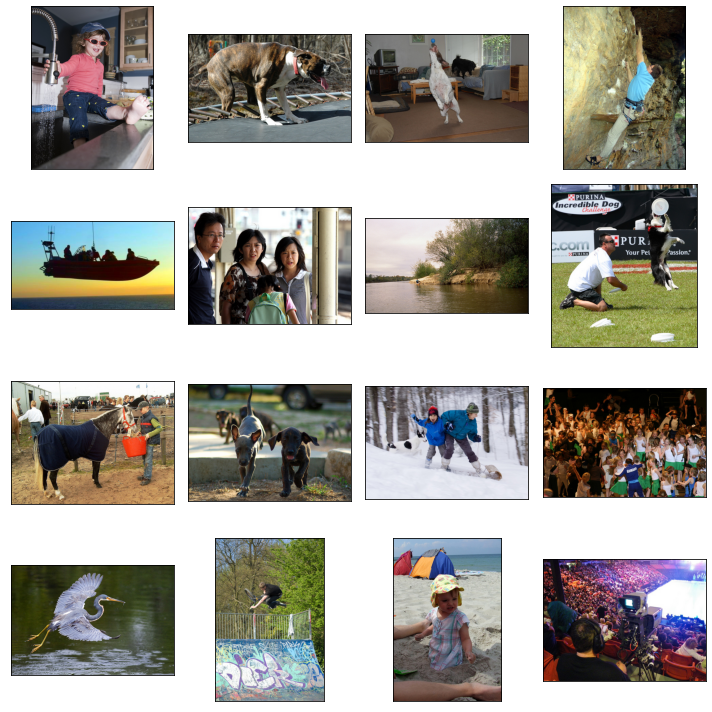

In [10]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(join(DATA_PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(join(DATA_PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** мы загрузили и ознакомились с данными из выборок. 
 
 Нам дан: обучающий датасет из 5822 пар изображение-описание
набор оценок экспертов, которые определяли соответствие описания изображдению, это те же 5822 записи фото-описание
набор тестовых запросов и изображений, на которых предстоит проверить качество работы обученных моделей.

Пересечений между наборами данных для трейна и теста не обнаружено.

**Агрегация выборок** для дальнейшего исследования и моделирования:

In [11]:
def expert_aggregate(row) -> object:

    #аггрегируем экспертную оценку усреднением ответов и сведением к единому виду

    if row['first'] != row['second'] != row['third']: #если оценки разные усредняем
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else: # но если есть одинаковые оценки - аггрегируем голосованием
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)

Объединим два DF с описанией краудсорсинга и экспертов для дальнейшей агрегации. Выберем outer join, тк для каких-то текстовых описаний отсутствуют оценки экспертах, в других - экспертов.

In [12]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

def score_aggregate(row) -> object:

    '''аггрегируем оценки людей и экспертов'''

    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['share_pos'] * 0.3
        
    return row

df_scores = df_scores.apply(score_aggregate, axis=1)

Выполняем самопроверку:

In [13]:
display(df_scores['score'].isna().value_counts())
df_scores['score'].describe()

False    51323
Name: score, dtype: int64

count    51323.000000
mean         0.075967
std          0.208417
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

Также объединим датасеты:

In [14]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [15]:
to_fill = df_train[df_train['query_text'].notna()]

Подчистим данные:

In [16]:
def fill_text(row) -> object:

    # заполним пропуски в датасете

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

df_train = df_train.apply(fill_text, axis=1)

In [17]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


**Вывод**: теперь  данные готовы к проверке.

## Проверка данных

В некоторых странах, где работает  компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Проведем лемметизацию текста, чтобы было проще из описаний картинок искать запрещенный контент.

In [18]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:

    # лемматизируем текст

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # приводим текст к одному регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизация
    text = [lemmatize.lemmatize(word) for word in text] # лемматизация

    return text

def cleaning(row) -> object:

   # отмечаем то, что нужно заблокировать

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [19]:
%time 
df_train = df_train.apply(cleaning, axis=1)

CPU times: total: 0 ns
Wall time: 0 ns


Посмотрим рандомный сэмпл заблокированных описаний:

In [20]:
print(df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique())

['A man in a suit dances with a young girl in front of an audience .'
 'A girl walks toward a herd of sheep in the distance .'
 'Two smiling little girls playing in a fountain with other people .'
 'A small boy with braids runs through a field of tall green grass .'
 'Two boys play with two dogs at the shore .'
 'Three children in neon colors play soccer while young man watches'
 'Laying on stones , a girl with messy hair has her head on the boy laying next to her .'
 'A young boy wearing a blue and red hat is using a camera near a swing set .'
 'A young boy rides a blue and yellow merry-go-round with an adult male hand in the foreground .'
 'A smiling child sits against a wall on a blanket and eats a snack .']


Посмотрим рандомный сэмпл из заблокированных фотографий:

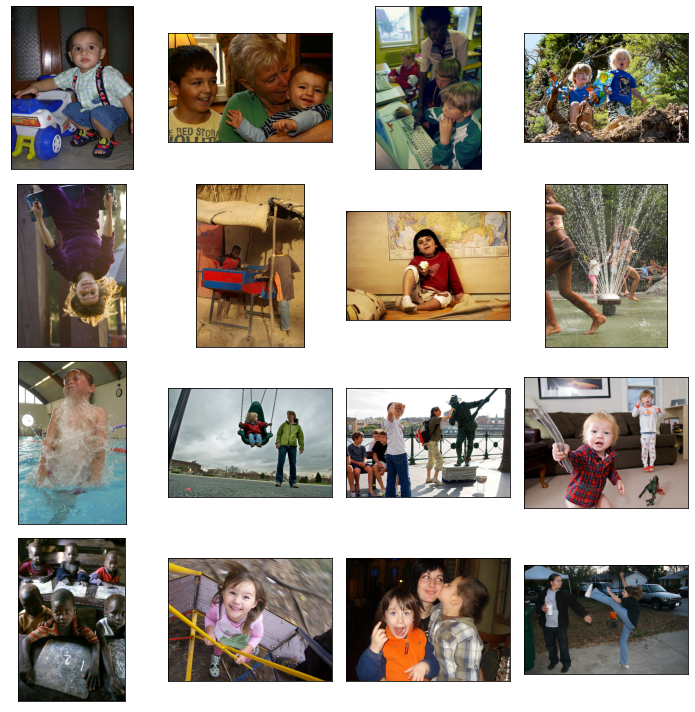

In [21]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(join(DATA_PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Удалим заблокированные данные и посмотрим как теперь выглядит датасет:

In [22]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

In [23]:
display(df_train.head(), df_queries.head())
df_train.info()
print('-' * 50)
df_queries.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text     score  
0  A man sleeps under a blanket on a city street .  0.000000  
1  A man sleeps under a blanket on a city street .  0.333333  
2  A man sleeps under a blanket on a city street .  0.233333  
3  A man sleeps under a blanket on a city street .  0.333333  
4  A man sleeps under a blanket on a city street .  0.000000

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   score       36125 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


**Вывод:** мы исключили запрещенную информацию.

## Векторизация изображений

В этом нам поможет архитектура ResNet-50

In [24]:
def load_train(path=DATA_PATH) -> ImageDataGenerator:
    
    # с помощью функции загрузим изображения через генератор
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=join(DATA_PATH, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

Посмотрим что выводит данный генератор

Found 36125 validated image filenames.


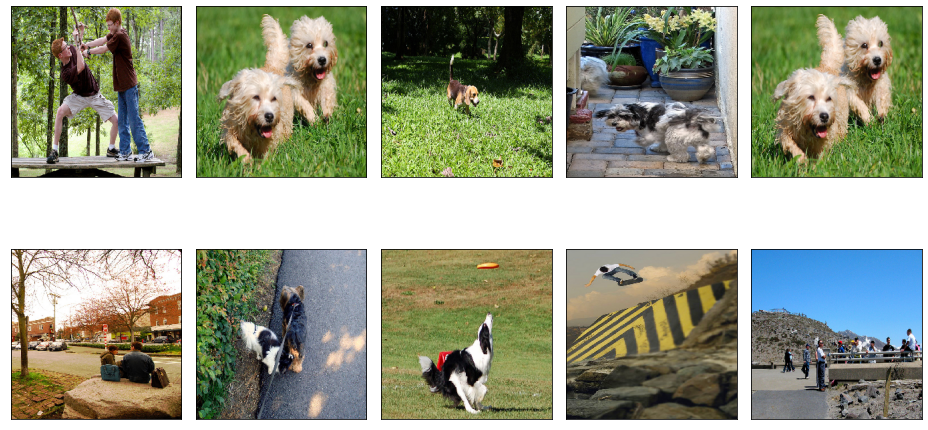

In [25]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Создадим модель:

In [26]:
def create_model(input_shape=(256, 256, 3)):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

Превратим данные в эмбенддинги, предварительно векторизировав данные:

In [27]:
def vectorize_pictures(model, train_data):
    
    pred = model.predict(train_data)
    
    return pred

In [28]:
pictures_embeds = vectorize_pictures(create_model(), load_train())

Found 36125 validated image filenames.
2258/2258 [==============================] - 2442s 1s/step


In [29]:
pictures_embeds.shape

(36125, 2048)

Картинки превратились в вектора.

##  Векторизация текстов

Используем для этого BERT из библиоетки Keras.

In [30]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

In [31]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [32]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [33]:
text = list(df_train['query_text'])

In [34]:
text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/1129 [00:00<?, ?it/s]

In [35]:
text_embeds.shape

(36125, 768)

Эмбеддинги текста готовы к дальнейшей работе.

##  Объединение векторов

Объединим полученные датасеты

In [36]:
X = np.concatenate((pictures_embeds, text_embeds), axis=1)
X.shape

(36125, 2816)

In [37]:
y = np.array(df_train['score'])
y.shape

(36125,)

Для облегченного подсчета используем:

In [38]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [39]:
with open('X.pickle', 'rb') as f:
    X = pickle.load(f)
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)
print(X.shape)
print(y.shape)

(36125, 2816)
(36125,)


## Обучение модели предсказания соответствия

Разделим выборки на обучающую и тестовую с помощью GroupShuffleSplit:

In [40]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [41]:
X_train, X_test = X[train_indices], X[test_indices] #признаки

In [42]:
y_train, y_test = y[train_indices], y[test_indices] #целевой признак

Приведем данные к единому масштабу с помощью StandardScaler:

In [43]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Первой моделью для обучения будет **LinearRegression** с оценочной метрикой RMSE:

In [44]:
%%time
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
score = cross_val_score(
    model, X_train, y_train, groups=df_train['image'].loc[train_indices],
    scoring='neg_root_mean_squared_error',
    cv=GroupShuffleSplit(random_state=SEED)
).mean()
abs(score).round(decimals=3)

CPU times: total: 3min 38s
Wall time: 43.7 s


0.219

Следующая модель **LinearSVR**:

In [45]:
model = LinearSVR(random_state=SEED)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=SEED),
    verbose=1
) # параметры модели подберем через GridSearchCV

In [46]:
%time 
gs_svr.fit(X_train, y_train, groups=df_train['image'].loc[train_indices])
None

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\yana\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Результаты на обучающей выборке:

In [47]:
pd.DataFrame(gs_svr.cv_results_)[['param_C', 'param_loss', 'mean_test_score', 'rank_test_score']].round(decimals=3)

param_C                   param_loss  mean_test_score  rank_test_score
0       1  squared_epsilon_insensitive           -0.267                1

Третья модель будет **нейронная сеть**

In [48]:
X_train.shape

(29214, 2816)

In [49]:
model_i = Sequential()
model_i.add(Dense(2816, input_shape=(2816,), activation='relu'))
model_i.add(BatchNormalization())
model_i.add(Dense(256, activation='relu'))
model_i.add(BatchNormalization())
model_i.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

model_i.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_i.build()

model_i.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2816)              7932672   
                                                                 
 batch_normalization (BatchN  (None, 2816)             11264     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               721152    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,666,369
Trainable params: 8,660,225
No

In [50]:
model_i.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10
913/913 - 42s - loss: 0.2128 - root_mean_squared_error: 0.4614 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274 - 42s/epoch - 46ms/step
Epoch 2/10
913/913 - 40s - loss: 0.0888 - root_mean_squared_error: 0.2980 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2894 - 40s/epoch - 44ms/step
Epoch 3/10
913/913 - 41s - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2493 - 41s/epoch - 45ms/step
Epoch 4/10
913/913 - 41s - loss: 0.0585 - root_mean_squared_error: 0.2419 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2515 - 41s/epoch - 45ms/step
Epoch 5/10
913/913 - 42s - loss: 0.0546 - root_mean_squared_error: 0.2338 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2469 - 42s/epoch - 46ms/step
Epoch 6/10
913/913 - 42s - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.0647 - val_root_mean_squared_error: 0.2544 - 42s/epoch - 46ms/step
Epoch 7/10
913/913 - 42s - loss: 0.0495 - root_mean_squared_error: 0.2

**Вывод:** лучше всего себя показали вторая и третья модель, далее их можем проверять на тестовых выборках.

##  Тестирование модели

Также для тестовой выборки сделаем эмбеддинги

In [51]:
def load_test(path=DATA_PATH) -> ImageDataGenerator:
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=join(DATA_PATH, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

In [52]:
pictures_embeds_test = vectorize_pictures(create_model(), load_test())
pictures_embeds_test.shape

Found 100 validated image filenames.
7/7 [==============================] - 7s 874ms/step


(100, 2048)

Создадим функцию для тестирования, которая будет включать в себя все вышепрошедшие этапы, а именно: проверка фото на запрещенный контент, работу с векторами и подбор текст-фото.

In [56]:
def get_picture(text) -> None:

    if [i for i in get_lemmas(text) if i in BLOCK]: 
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False)
        X = np.concatenate(( 
            pictures_embeds_test,
            np.resize(text_embed, (pictures_embeds_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = model_i.predict(X) 
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) 
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) 
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) 
        
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        
        fig = plt.figure(figsize=(15,5)) 
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(join(DATA_PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if text in list(df_queries['query_text']): 
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(join(DATA_PATH, 'test_images', 
                                    df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        plt.show()

    return None

Создадим рандомный сэмпл из тестовой выборки и прогоним его через тестирующую функцию.

In [57]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['Boy wearing a green and white soccer uniform running through the grass .',
 'The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence .',
 'A person jumping off a dock into water .',
 'A man and two boys standing in spraying water .',
 'A dog is catching a yellow tennis ball on the beach .',
 'Two people are running at the top of a mountain .',
 'Two children wearing jeans squirt water at each other .',
 'A man is doing a jump on a wakeboard in the water .',
 'A playground with two children and an adult .',
 'The dog is sitting on the side of the hill .']


-------------------- Boy wearing a green and white soccer uniform running through the grass . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 10ms/step

-------------------- The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence . --------------------



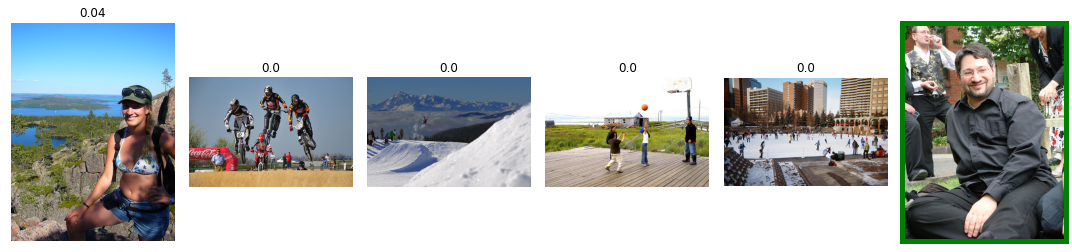

4/4 [==============================] - 0s 10ms/step

-------------------- A person jumping off a dock into water . --------------------



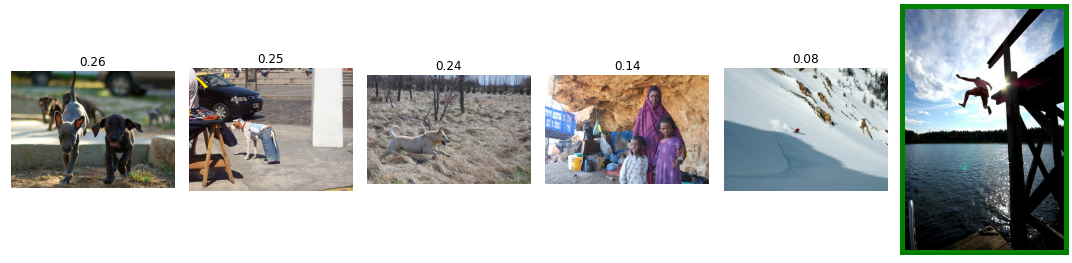


-------------------- A man and two boys standing in spraying water . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 10ms/step

-------------------- A dog is catching a yellow tennis ball on the beach . --------------------



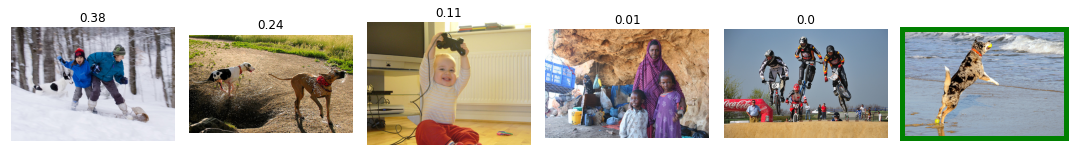

4/4 [==============================] - 0s 10ms/step

-------------------- Two people are running at the top of a mountain . --------------------



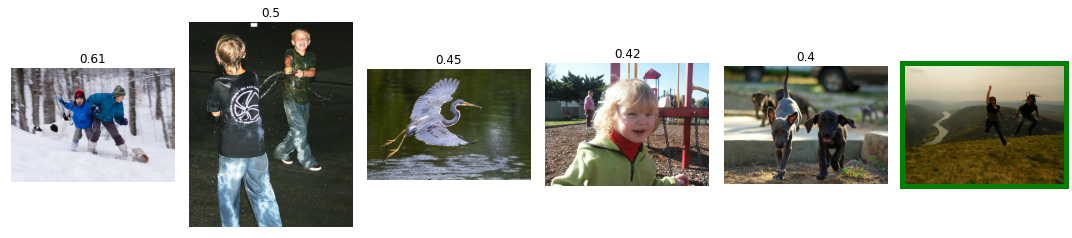


-------------------- Two children wearing jeans squirt water at each other . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 10ms/step

-------------------- A man is doing a jump on a wakeboard in the water . --------------------



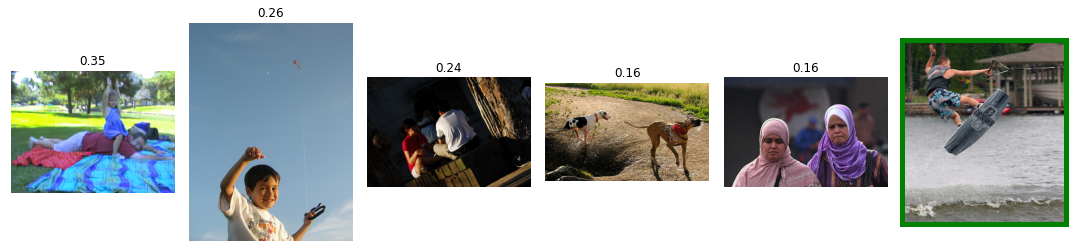


-------------------- A playground with two children and an adult . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 10ms/step

-------------------- The dog is sitting on the side of the hill . --------------------



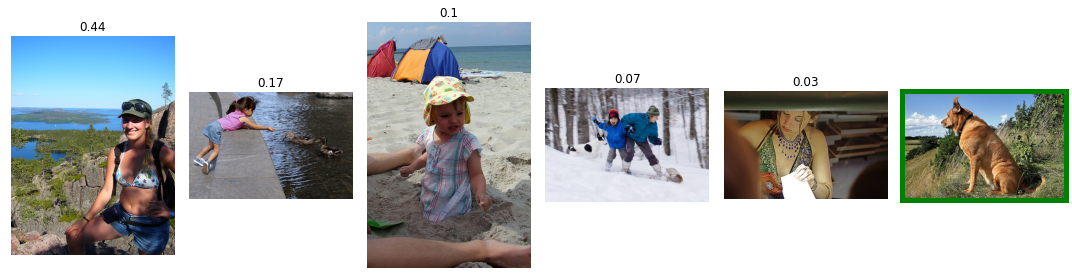

In [58]:
for text in text_test:
    get_picture(text)

## Вывод:

Обе модели показали себя опять очень сходно в смысле прогнозов изображений, их попадания на тестовой выборке достаточно хороши.

В ходе работы были исследованы данные, проверены и затем исключены запрещенные данные из датасетов с помощью лемматизации текстов-описаний. Мы векторизировали фото и текст, затем объединили их для дальнейшего преобразования и моделирования. 

Для проекта были рассмотрены модели:
 - LinearRegression
 - LinearSVR
 - Нейронная сеть;
 
Мы протестировали конечным этапом нейронную сеть и она дала нам относительную жизнеспособность, но все таки проект требует доработки.

##  Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска